In [1]:
import numpy as np
import pandas as pd
import pygame as pg
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# Tensorflow
import tensorflow.keras.backend as K
# Car Game
import race_car
# GA with ANN
import ann_ga

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Tensorflow Version: 2.3.0


# Variables

In [2]:
generations = 1000
pop_size = 30
best_fitness = 0
best_id = 0
best_fitness_avg = 0
final_reward = 10
avg_reward = 0
population = []
pop_playing = []
fitness = []
new_population = []
best_weights = []
tree = []
df_players = pd.DataFrame(columns=['GENERATION','ID','REWARD','ANN'])

# Start a New Game
Inform the size of the population

In [3]:
game = race_car.Game(pop_size)
game.new()

## Game Loop

In [4]:
# Start game loop
for generation in range(generations):
    clear_output(wait=True) # clear the Print/Output
    if len(population)>0:
        display('- Best Player is {0:.0f}, with the Fitness {1:.3f}!'.format(best_id,best_fitness))

    display('## Generation: {0:.0f} ##'.format(generation))
    if len(population)>0:
        display('- Starting Childs from Last Generation - {0:.0f} childs'.format(len(population)))
        # Create a child and add to networks
        for i in range(5):
            # Crossover the best player with others to create 10 childs
            child = population[order_fit[0][0]].crossover(population[order_fit[i%4+1][0]])
            new_population.append(child[0])
            new_population.append(child[1])
            tree.append([order_fit[0][0], order_fit[i%4+1][0]]) # to save parent information
            tree.append([order_fit[i%4+1][0], order_fit[0][0]])

        # Based on weighted list, generate childs - Roulette Wheel Selection
        # To fill the size of the population
        w_order_fit = population[0].ProbList(order_fit) # Get weighted list of players
        for id in range(len(new_population), pop_size):
            x = population[0].FChoices(order_fit, w_order_fit, 2)
            child = population[x[0][0]].crossover(population[x[1][0]])
            new_population.append(child[0])
            new_population.append(child[1])
            tree.append([x[0][0], x[1][0]])
            tree.append([x[1][0], x[0][0]])

    # Clear the data for a New Generation
    population.clear()
    fitness.clear()
    pop_playing.clear()
    best_fitness = 0

    # Create all Neural Networks and Players
    display('- Starting New Game...')
    for idx, car in enumerate(game.car):
        if len(new_population)>0:
            population.append(new_population[idx])
        else: # First Generation
            population.append(ann_ga.GNN(input_size=15, output_size=4))
            tree.append([-1, -1])
        fitness.append([idx, -999])
        pop_playing.append(1)
        car.ini() # start each car
        
    new_population.clear()
    display('! Running !')
    while sum(pop_playing)>0:# While cars are playing
        for idx, car in enumerate(game.car): # Car Updates
            if car.playing:
                playing, reward, state = car.update() # get the state of the car
                action = population[idx].select_action(state) # select the action
                car.event(action)
                fitness[idx][1] = reward 
                if reward >= final_reward:
                    car.playing = False # Stop - We have our Best Model
                if not car.playing:
                    pop_playing[idx] = 0 # If the player has lost, I no longer need to update 
        game.run(sum(pop_playing)) # Run this game step (update screen)
    display('- End of this Generation!')
    order_fit = sorted(fitness,key=lambda l:l[1], reverse=True)
    best_fitness = order_fit[0][1]
    best_id = order_fit[0][0]
    
    display('- Selecting and Saving the Best Player...')
    for idx, each in enumerate(order_fit):
        if idx<10: # save the 10 firsts
            population[each[0]].save_weights(idx)
        df_players = df_players.append({'GENERATION':generation, 
                                        'PARENTS':tree[each[0]], 
                                        'ID':each[0], 
                                        'REWARD':each[1], 
                                        'ANN':population[each[0]].network.get_weights() if idx<10 else None}, 
                                       ignore_index=True)
    
    tree.clear() # Clear the Parent Tree
    K.clear_session() # Tensorflow memory leak
    
    if best_fitness >= final_reward: # 10 Consecutive Laps
        avg_reward += 1
        if avg_reward > 3:
            game.running = False
    else:
        avg_reward = 0

    if not game.running:
        break

# To save information about all Generations
population[0].save_history(df_players)

clear_output(wait=True) # clear the Print/Output
display('## Generation: {0:.0f} ##'.format(generation))
display('- Best Player is {0:.0f}, with the Fitness {1:.3f}!'.format(best_id,best_fitness))

pg.display.quit()

'## Generation: 161 ##'

'- Best Player is 17, with the Fitness 10.061!'

<AxesSubplot:xlabel='GENERATION'>

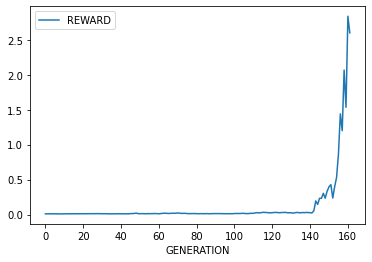

In [5]:
# Average Reward
df_players.groupby(['GENERATION'])[['REWARD']].mean().plot.line()

<AxesSubplot:xlabel='GENERATION'>

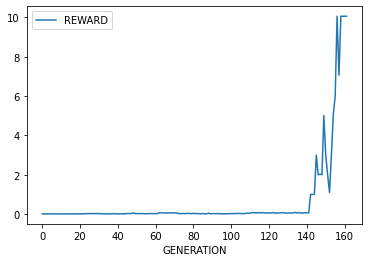

In [6]:
# Best Player of Each Generation
df_players.groupby('GENERATION')[['GENERATION','REWARD']].head(1).plot.line(x='GENERATION', y='REWARD')